### 2020 Lavickova et al. A self-regenerating synthetic cell model: Model plots, resource allocation
Nadanai Laohakunakorn (University of Edinburgh), nadanai.laohakunakorn@ed.ac.uk

In [1]:
using DelimitedFiles
using Plots
using DifferentialEquations
using ProgressBars
using Statistics
using PyCall

include("../scripts/models.jl");
include("../scripts/callbacks.jl");
include("../scripts/solve.jl");

In [2]:
# Global settings
Plots.pyplot()
PATH_OUT = "../output/"
fntsm = Plots.font("sans-serif", pointsize=round(14.0))
fntlg = Plots.font("sans-serif", pointsize=round(18.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)

TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.2;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between experimental stages

# Define names for species indices
idx_R=1;
idx_dT=2;
idx_dG=3;
idx_mT=4;
idx_mG=5;
idx_pT=6;
idx_pG=7;

idx_TX = 8;
idx_TL = 9;

## 3. Resource allocation time series

### First deal with averaging between dilution steps

In [3]:
function averagerates(solDU)
    
    inds = findall(x -> x.%15==0.0, solDU.t)
    nrinds = size(inds)[1]
    t = solDU.t/60;

    time = [0.0]
    avgTXT = [0.0]
    avgTXG = [0.0]
    avgTLT = [0.0]
    avgTLG = [0.0]

    TXT = [datum for subarr in solDU.saveval for datum in subarr[idx_mT]];
    TXG = [datum for subarr in solDU.saveval for datum in subarr[idx_mG]];
    TLT = [datum for subarr in solDU.saveval for datum in subarr[idx_pT]];
    TLG = [datum for subarr in solDU.saveval for datum in subarr[idx_pG]];
    
    for j in 1:(nrinds-1)
        append!(avgTXT,mean(TXT[inds[j]:inds[j+1]]))
        append!(avgTXG,mean(TXG[inds[j]:inds[j+1]]))
        append!(avgTLT,mean(TLT[inds[j]:inds[j+1]]))
        append!(avgTLG,mean(TLG[inds[j]:inds[j+1]]))
        append!(time,t[inds[j+1]])
    end
    
    return(time,avgTXT,avgTXG,avgTLT,avgTLG)
end

averagerates (generic function with 1 method)

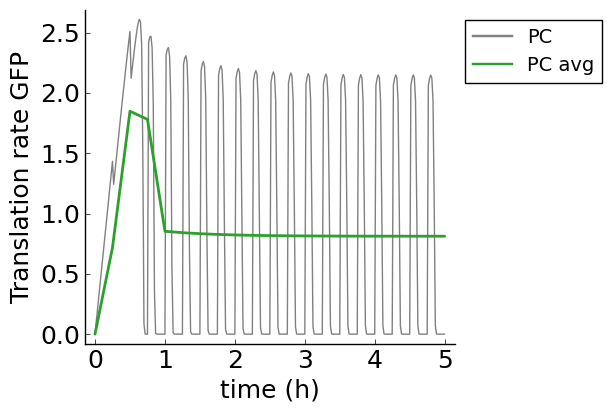

In [4]:
# 1.2A Average vs maximum rates

CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pl1 = plot(grid=:false,legend=:outertopright)
FN="minmaxavg.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:1.0:5*60 # either array or range can be passed
#TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solDU.t/60;
pcTLG = [datum for subarr in solDU.saveval for datum in subarr[idx_pG]];
plot!(t,(pcTLG),label="PC",color=:gray,xaxis="time (h)",
    yaxis="Max translation GFP",lw=1);

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.1*alpha;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.2:5*60 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLG,label="PC avg",color="#2ca02c",xaxis="time (h)",
    yaxis="Translation rate GFP",lw=2);

pl1 # Show plot
savefig(PATH_OUT*FN)

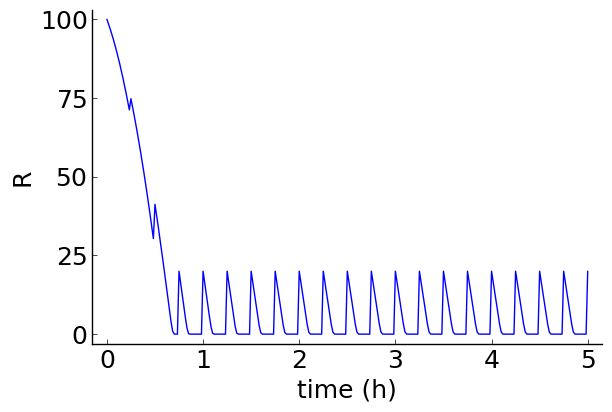

In [5]:
# 1.2A Average vs maximum rates

CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pl2 = plot(grid=:false,legend=:false)#,legend=:outertopright)
FN="minmaxavg_R.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:1.0:5*60 # either array or range can be passed 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pcR = [datum for subarr in solU.u for datum in subarr[idx_R]];
plot!(t,(pcR),label="PC",color="blue",xaxis="time (h)",
    yaxis="R",lw=1);

pl2 # Show plot
savefig(PATH_OUT*FN)

### Then look at rates

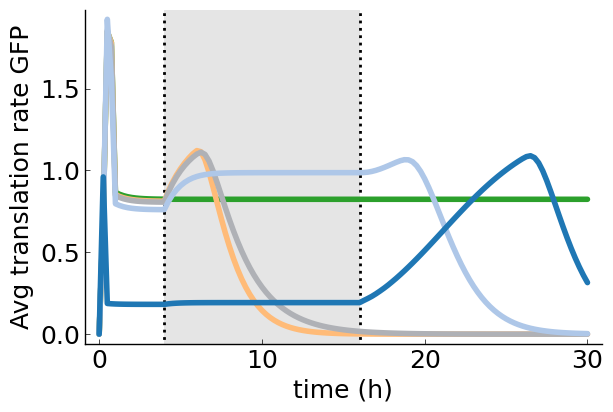

In [6]:
# 3.1 TL GFP
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p5 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="rate_TL_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLG,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg translation rate GFP",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLG,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTLG,label=LABELS[j],color=COLOURS[j],lw=4);

end

p5 # Show plot
savefig(PATH_OUT*FN)

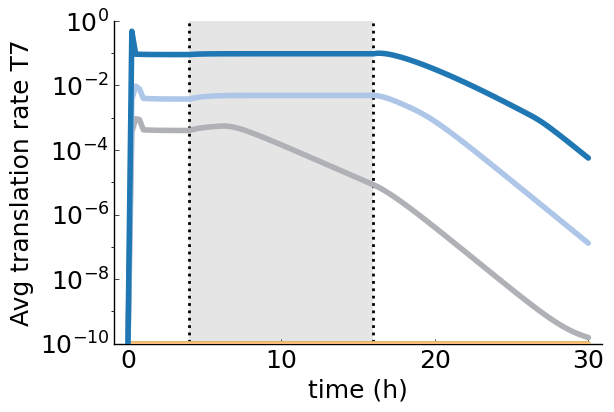

In [7]:
# 3.2 TL T7
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p6 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
ylims!((1e-10,1e-0))
FN="rate_TL_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLT.+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg translation rate T7",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLT.+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTLT.+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

p6 # Show plot
savefig(PATH_OUT*FN)

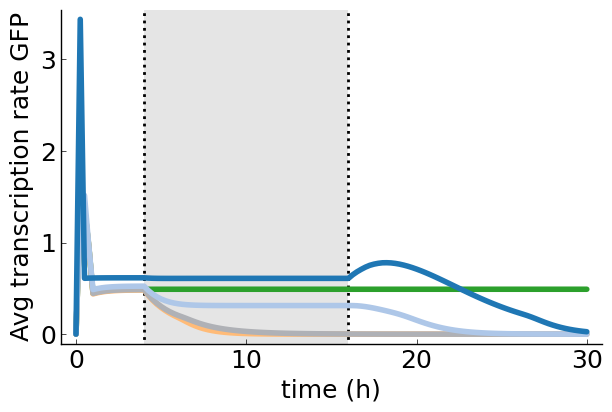

In [8]:
# 3.3 TX GFP
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p7 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="rate_TX_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXG,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg transcription rate GFP",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXG,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTXG,label=LABELS[j],color=COLOURS[j],lw=4);

end

p7 # Show plot
savefig(PATH_OUT*FN)

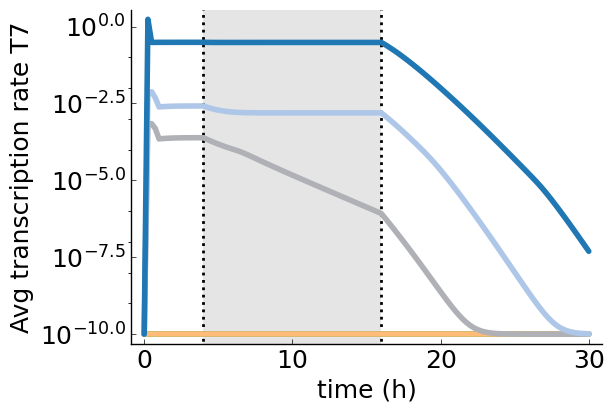

In [9]:
# 3.4 TX T7
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p8 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="rate_TX_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXT.+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg transcription rate T7",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXT.+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTXT.+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

p8 # Show plot
savefig(PATH_OUT*FN)

### Then look at allocation

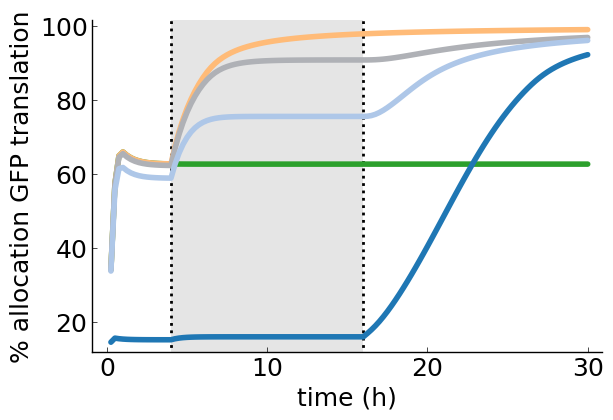

In [10]:
# 3.5 RA TL GFP
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TL_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation GFP translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll1 # Show plot
savefig(PATH_OUT*FN)

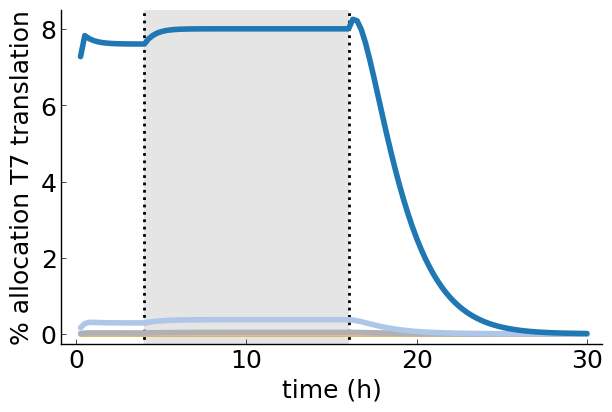

In [11]:
# 3.6 RA TL T7
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll2 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TL_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll2 # Show plot
savefig(PATH_OUT*FN)

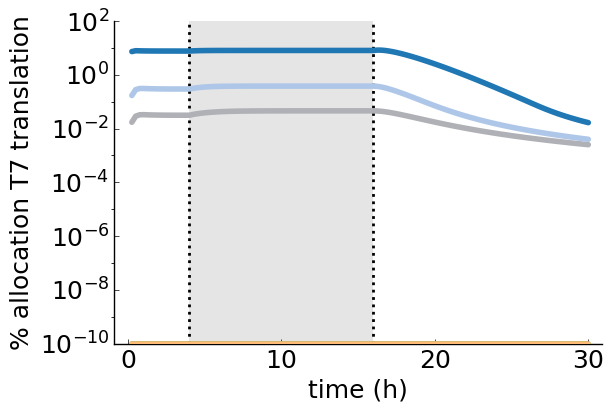

In [12]:
# 3.6 RA TL T7 log scale
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll2 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
ylims!((1e-10,1e2))
FN="RA_TL_T7log.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

pll2 # Show plot
savefig(PATH_OUT*FN)

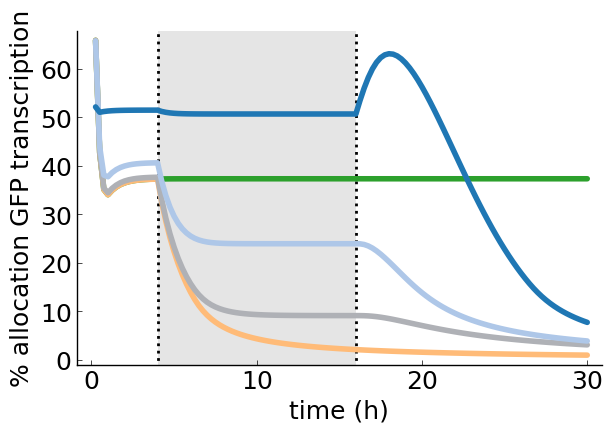

In [13]:
# 3.7 RA TX GFP
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll3 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TX_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation GFP transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll3 # Show plot
savefig(PATH_OUT*FN)

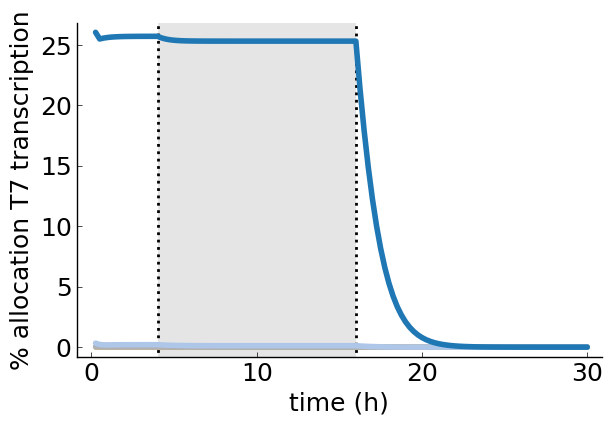

In [14]:
# 3.8 RA TX T7
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll4 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TX_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll4 # Show plot
savefig(PATH_OUT*FN)

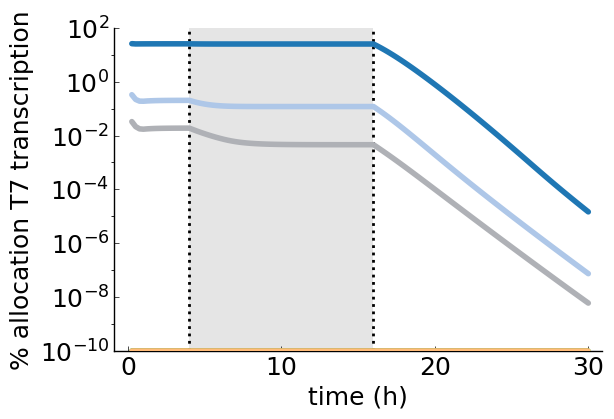

In [15]:
# 3.8 RA TX T7 log scale
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll4 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
ylims!((1e-10,1e2))
FN="RA_TX_T7log.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

pll4 # Show plot
savefig(PATH_OUT*FN)

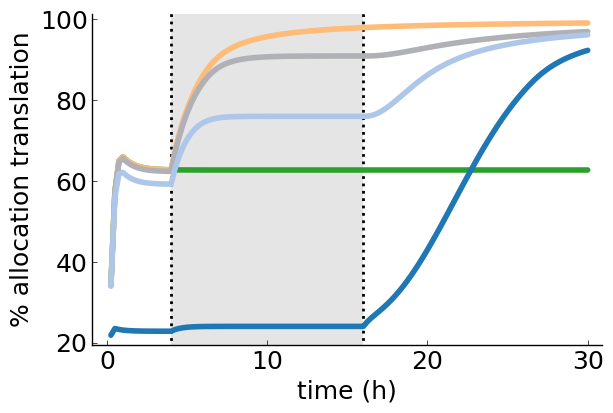

In [16]:
# 3.9 RA TL total
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll5 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TL.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTLG+avgTLT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTLG+avgTLT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*(avgTLG+avgTLT)./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll5 # Show plot
savefig(PATH_OUT*FN)

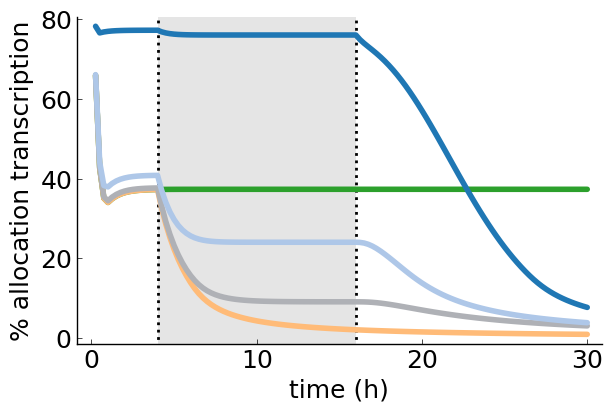

In [17]:
# 3.10 RA TX total
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
pll6 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TX.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTXG+avgTXT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTXG+avgTXT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*(avgTXG+avgTXT)./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll6 # Show plot
savefig(PATH_OUT*FN)

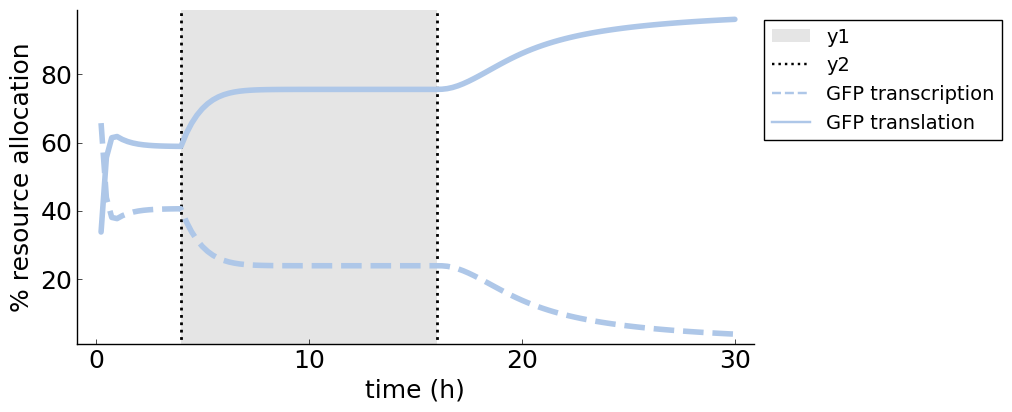

In [18]:
# 3.11 RA timeseries

CONCS = [0.01]
LABELS = ["GFP transcription","GFP translation"]
COLOURS = ["#aec7e8"]
pll3 = plot(grid=:false,legend=:outertopright,xaxis="time (h)",
    yaxis="% resource allocation")
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="fig_RA.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX


dT0=CONCS[1]
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
time1,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time1,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[1],color=COLOURS[1],lw=4,linestyle=:dash,size=(1000,400));


dT0=CONCS[1]
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
time2,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time2,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[2],color=COLOURS[1],lw=4);


pll3 # Show plot
savefig(PATH_OUT*FN)